In [1]:
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.stats import mad_std

%matplotlib inline


19.0.0


Load two red and blue sythesized flats generated by Celine

In [2]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,1,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_blue_-211.815_-0.395.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,1,["imaging"])["imaging"]))

464.05449439225345
459.6066877367366


Load a superflat generated by Eric

In [3]:
fname = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superflat/RTM-013/RTM-013-10982-S21_superflat_normal_h.fits"
ts8flat = get_ccd_from_id(None, fname, [])

In [4]:
print( mad_std(get_data_as_read(ts8flat,1,["imaging"])["imaging"] ) )

250.80880576883635


Let's take a ratio. We only see one channel #1.

In [5]:
ratio_red=get_data_as_read(ccob_red,1,["imaging"])["imaging"] / get_data_as_read(ts8flat,1,["imaging"])["imaging"]
ratio_blue=get_data_as_read(ccob_blue,1,["imaging"])["imaging"] / get_data_as_read(ts8flat,1,["imaging"])["imaging"]

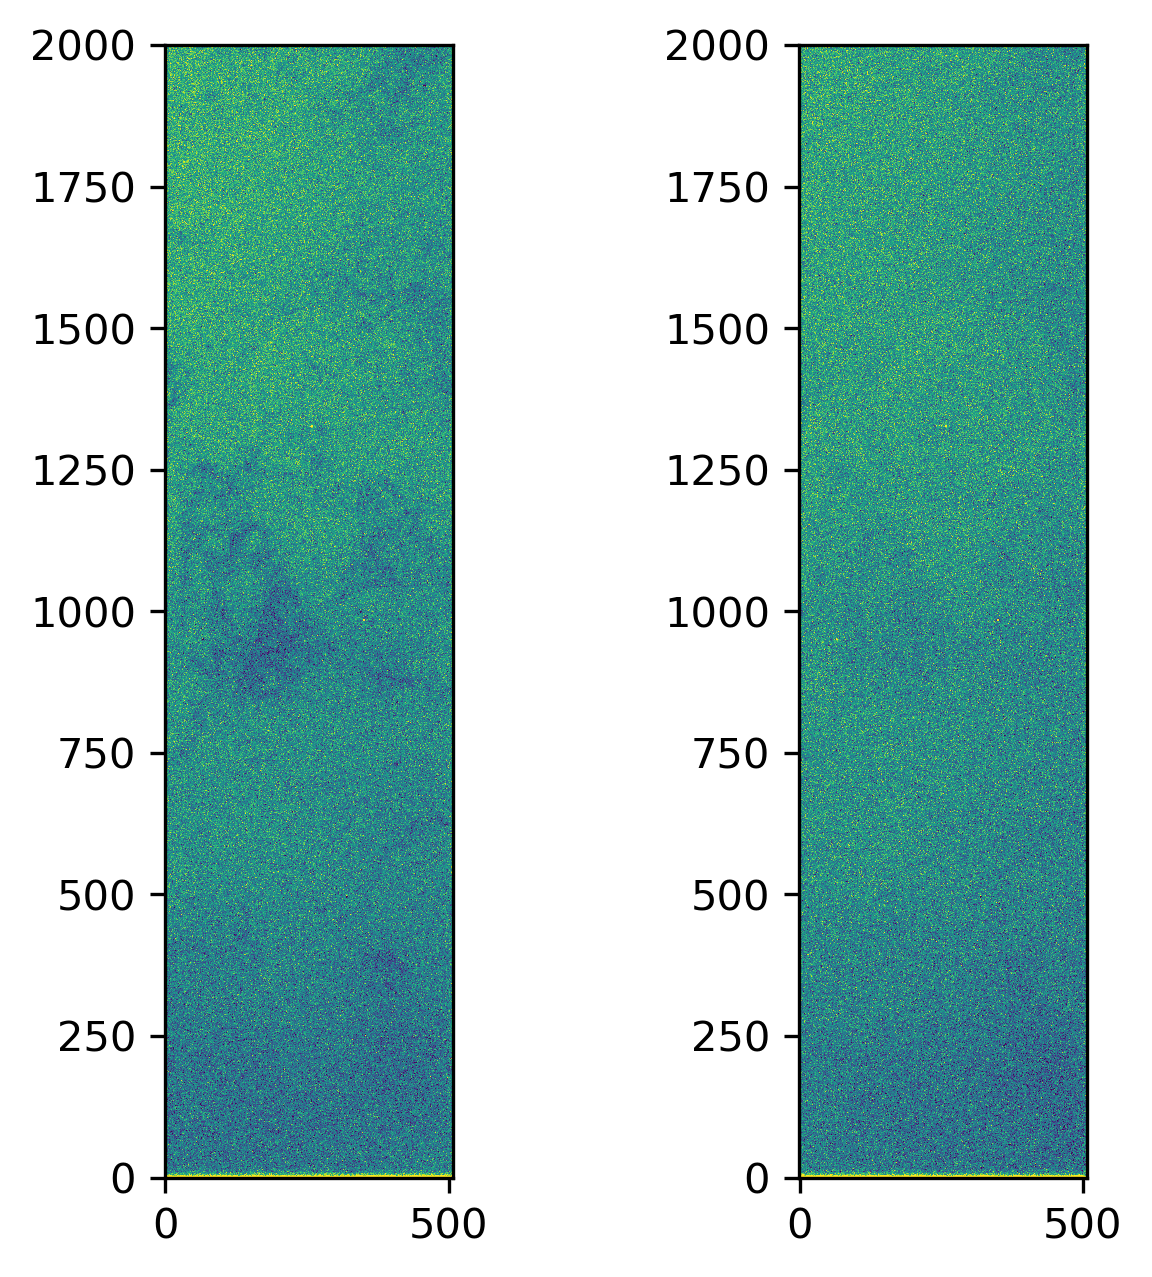

In [6]:

fig, axs = pylab.subplots(1,2,figsize=(5,5),dpi=300) 

for i, img in enumerate([ ratio_red, ratio_blue ]):
    subsec = img[:2000,:512]
    std = mad_std(subsec)
    mean = subsec.mean()
    N = 3
    axs[i].imshow(subsec,origin="lower",vmin=mean-N*std,vmax=mean+N*std)

https://github.com/LSSTScienceCollaborations/StackClub/tree/master/Visualization

"Color-Color diagram" of flat

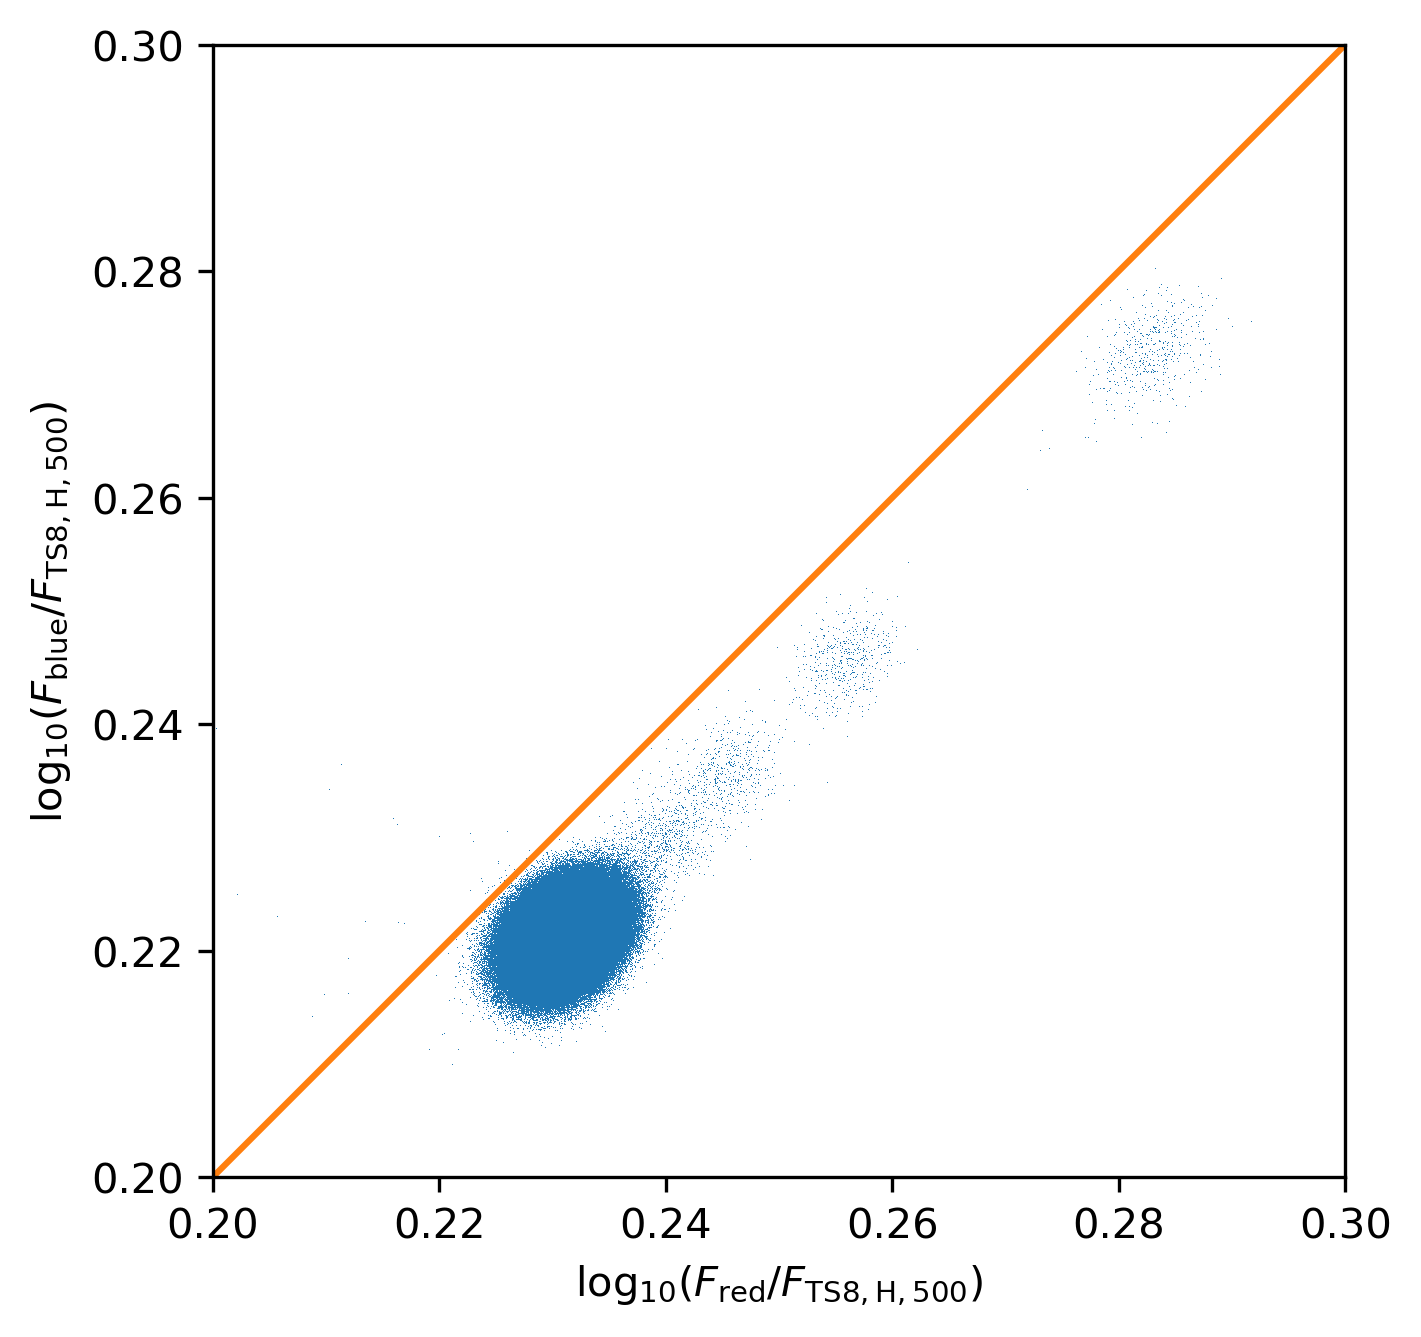

In [7]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
pylab.plot(
    numpy.log10(ratio_red.flatten()[::1]),
    numpy.log10(ratio_blue.flatten()[::1]),
    ","
)

x = numpy.arange(0,1,0.1)
pylab.xlabel(r"$\log_{10}(F_{\rm red}/F_{\rm TS8, H, 500})$")
pylab.ylabel(r"$\log_{10}(F_{\rm blue}/F_{\rm TS8, H, 500})$")
pylab.plot(x,x,"-")
pylab.xlim(0.2,0.3)
pylab.ylim(0.2,0.3)
ax = pylab.gca()
ax.set_aspect(1)

Questions are 
- The main island represent they are almost same color. But Why the main island does look elongated? 
    - probably due to the intrinsic scatter in $F_{\rm TS8, H, 500}$
- Why are there outliers along with line? Also I see at least three distinct islands. How are they distributed in a CCD?
    - one possible reason will be difference in coating. But can't explain the two distribution
- What are the outliers?
    - probably they are defects or cosmic ray or something like artifacts but need to be checked.

Let's look how they distribute

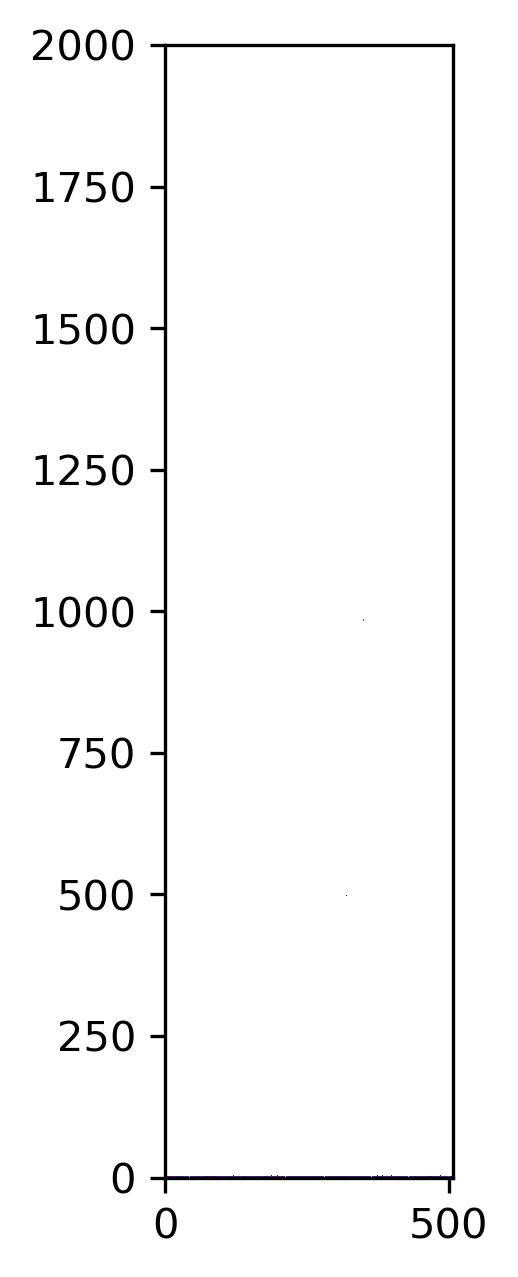

In [8]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
x = numpy.log10(ratio_red)
y = numpy.log10(ratio_blue)
img = x.copy()
img[numpy.where( numpy.logical_not( ( x>0.24 ) & ( x<0.3 )& ( y>0.23 ) & ( y<0.3 )) ) ] = numpy.nan
pylab.imshow(img ,origin="lower")

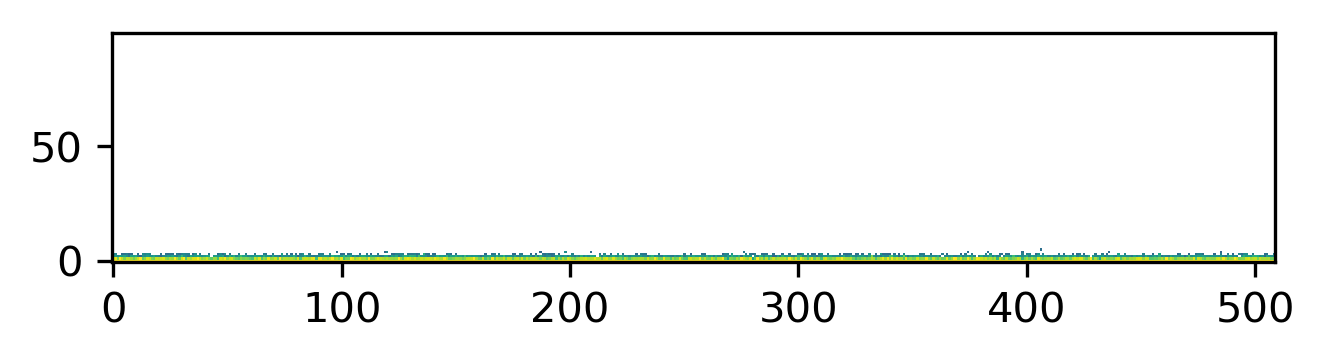

In [9]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
pylab.imshow(img[0:100] ,origin="lower", vmin=0.23, vmax=0.26)

Text(0.5, 0, 'row number')

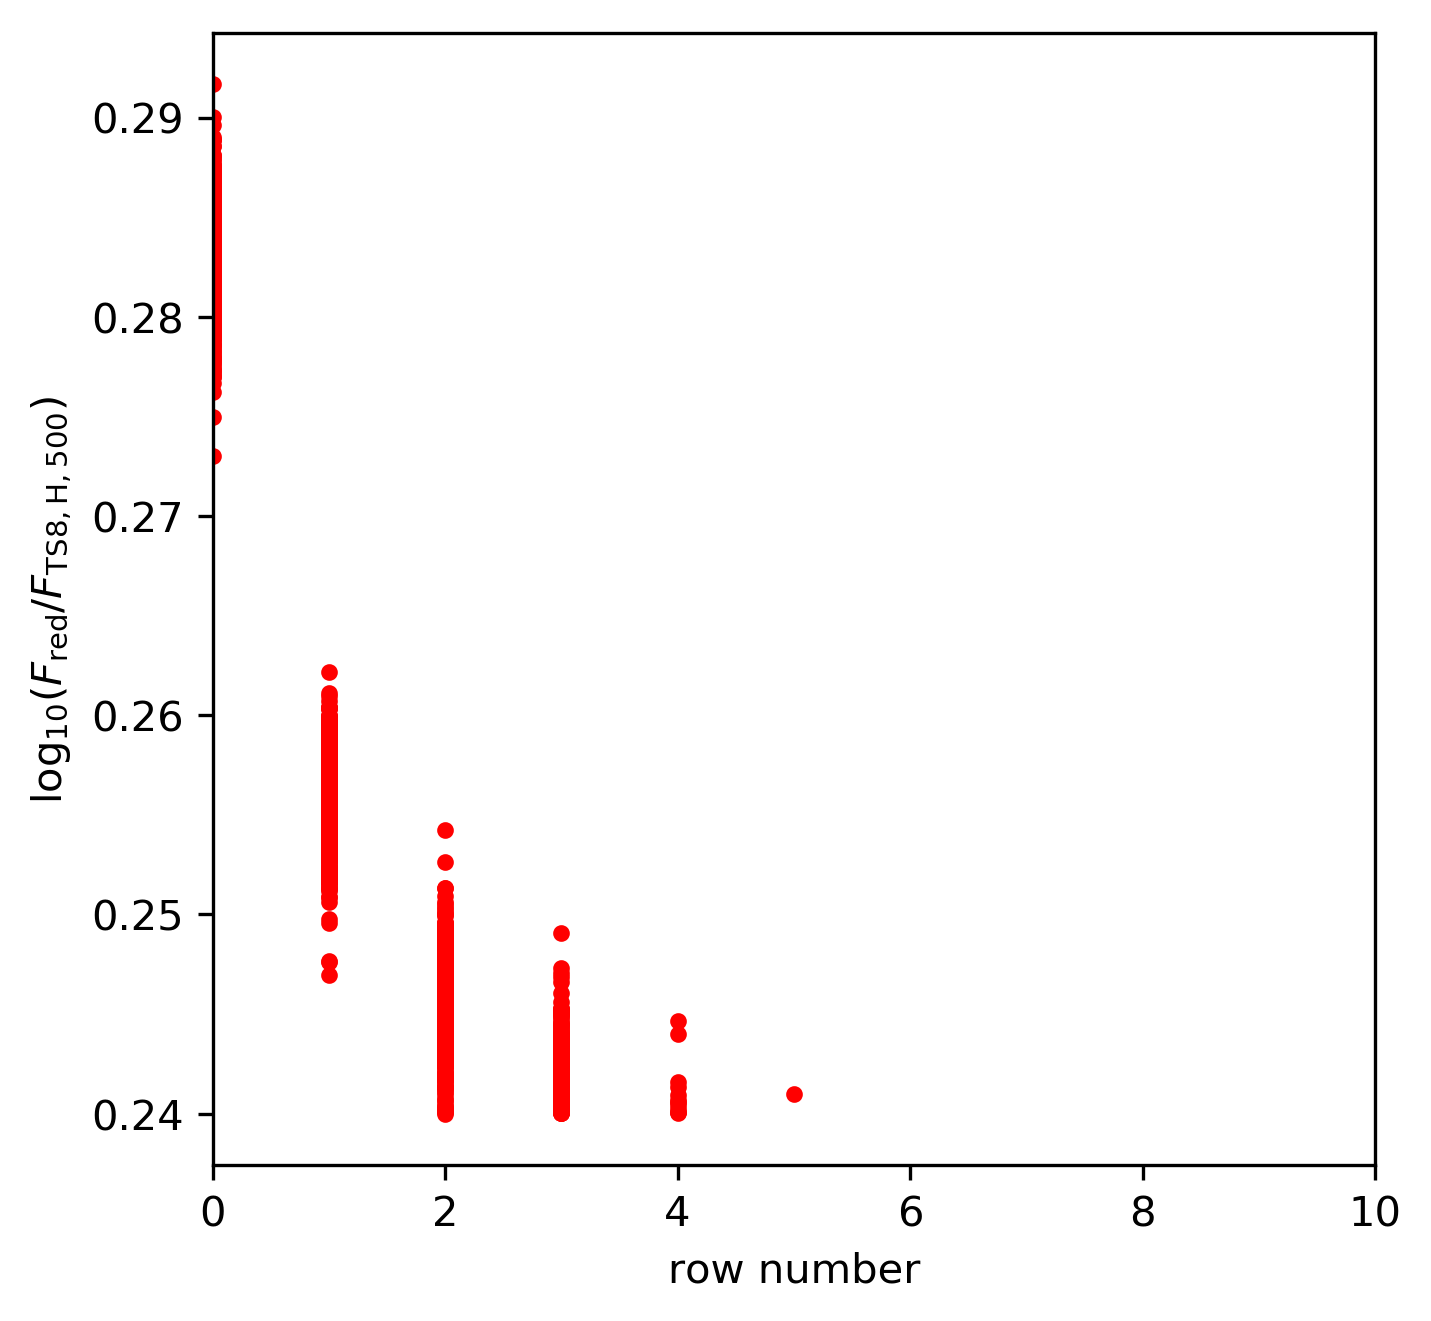

In [10]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
pylab.plot(img,"r.")
#pylab.plot(numpy.median(img,axis=1))
pylab.xlim(0,10)
pylab.ylabel(r"$\log_{10}(F_{\rm red}/F_{\rm TS8, H, 500})$")
pylab.xlabel("row number")

So edges are not gray.

---
Let's take a closer look with seaborn package. Execute the following command (only the first time)
```
!pip install seaborn --user
```
Add this line in your `~/notebooks/.user_setups`
```
export PYTHONPATH="~/.local/lib/python3.7/site-packages":${PYTHONPATH}
```

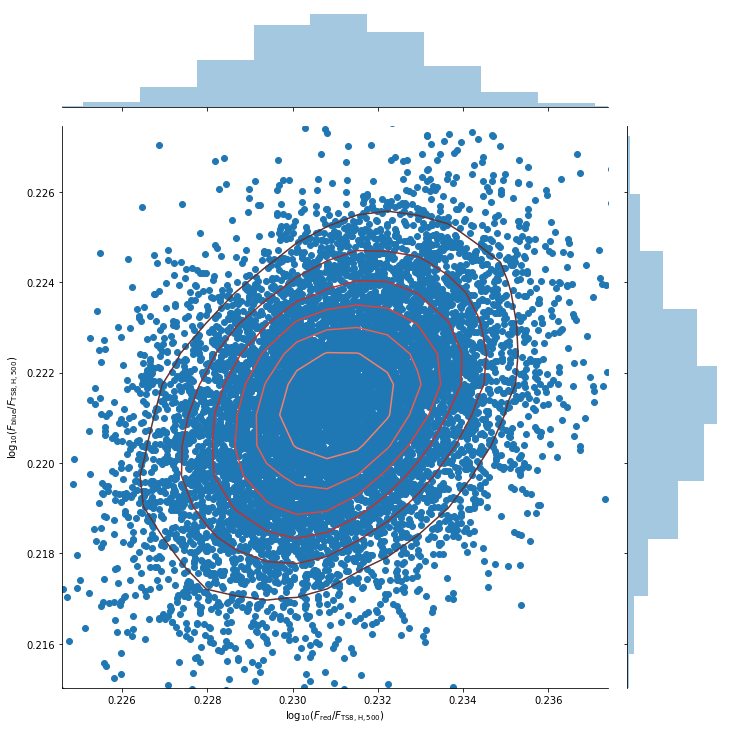

In [36]:
import seaborn as sns

n = 100
x = numpy.log10(ratio_red.flatten())
y = numpy.log10(ratio_blue.flatten())
mx = numpy.median(x)
my = numpy.median(y)
sx = mad_std(x)
sy = mad_std(y)
N = 3
g=sns.jointplot(
    x[::n],
    y[::n],
    height=10,
    xlim=[mx-N*sx,mx+N*sx],
    ylim=[my-N*sy,my+N*sy]
)
g.plot_joint(sns.kdeplot,zorder=10, cmap="Reds_d", n_levels=6)
g.set_axis_labels(
    r"$\log_{10}(F_{\rm red}/F_{\rm TS8, H, 500})$",
    r"$\log_{10}(F_{\rm blue}/F_{\rm TS8, H, 500})$"
)
C=numpy.cov(x,y)

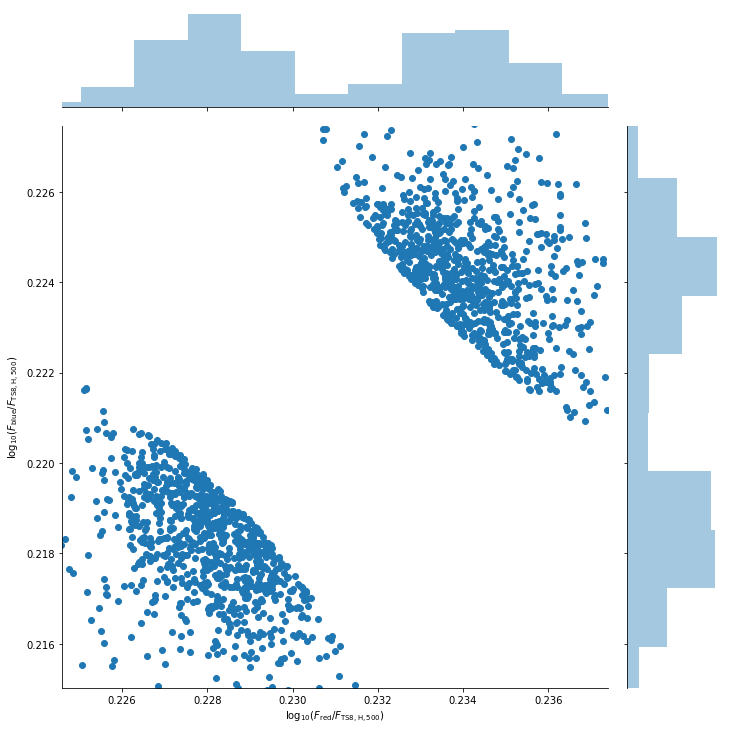

In [41]:
X = numpy.array(
    [ x-mx, y-my ]
).T

sigma = numpy.array([ a.T@C**-1@a for a in X ])
cond=numpy.where(sigma>3)
g=sns.jointplot(
    x[cond][::n],
    y[cond][::n],
    height=10,
    xlim=[mx-N*sx,mx+N*sx],
    ylim=[my-N*sy,my+N*sy]
)
#g.plot_joint(
#    sns.kdeplot,zorder=10, cmap="Reds_d", n_levels=6
g.set_axis_labels(
    r"$\log_{10}(F_{\rm red}/F_{\rm TS8, H, 500})$",
    r"$\log_{10}(F_{\rm blue}/F_{\rm TS8, H, 500})$"
)

1.6604988797283642 1.7442312018298634
1.6248243500856927 1.7042159388394782
-0.041787348943377545 6.996969774464506


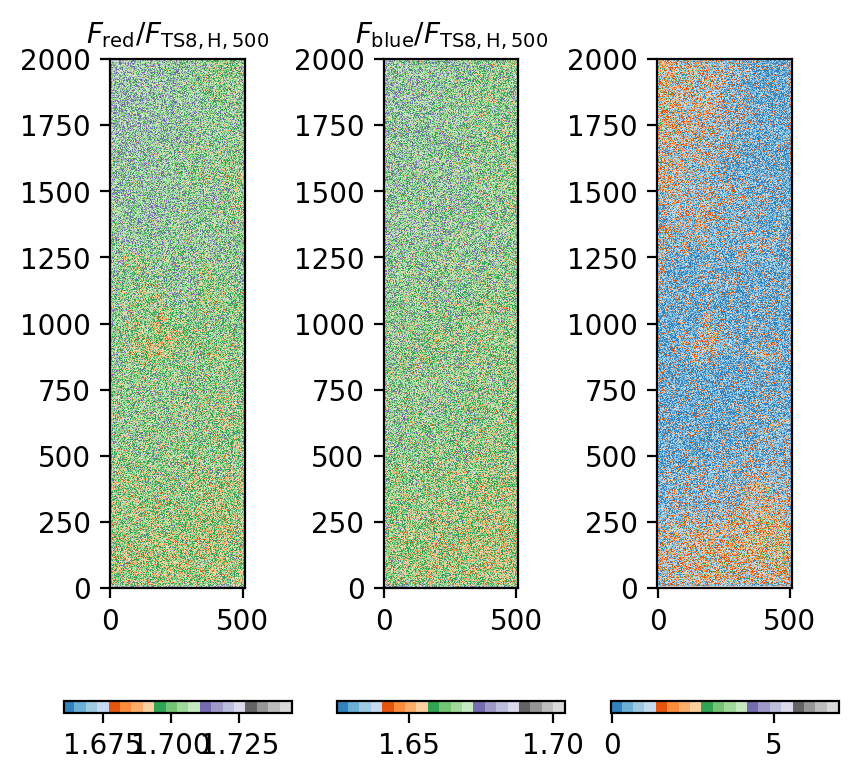

In [42]:
from matplotlib import cm
from scipy.ndimage import gaussian_filter

x = numpy.log10(ratio_red)
y = numpy.log10(ratio_blue)
I = sigma.reshape(ratio_red.shape).copy()
I[numpy.where( numpy.logical_not(
    (sigma**2>3**2).reshape(ratio_red.shape)
#    & ( mx-N*sx<x ) & ( x<mx+N*sx )& ( mx-N*sy<y ) & ( y<mx+N*sy )
) ) ] = 0

I = gaussian_filter(I,1)
fig, axs = pylab.subplots(1,3,figsize=(5,5),dpi=200) 

for i, var in enumerate([ 
    (ratio_red,r"$F_{\rm red}/F_{\rm TS8, H, 500}$"),
    (ratio_blue,r"$F_{\rm blue}/F_{\rm TS8, H, 500}$"),
    (I,"")
    ]):
    img, title = var
    subsec = img[:2000,:512]
    std = mad_std(subsec)
    mean = subsec.mean()
    level = 5
    print(mean-level*std,mean+level*std)
    axs[i].set_title(title,fontsize=10)
    im = axs[i].imshow(subsec,origin="lower",vmin=mean-level*std,vmax=mean+level*std,cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=axs[i], orientation="horizontal")
